In [2]:
local = True

In [3]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [4]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

In [5]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [6]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)

In [7]:
# Import libraries
import numpy as np
import os
import pickle

In [8]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = 0 #cpu.cpu_count() #- 1
# how many samples per batch to load
batch_size = 64

model_name =   "TransNet_Efficientnetb0" #"TransNet_Resnet18" #
input_shape =  (64,512) if model_name == "TransNet_Resnet18" else (64,1280)
batch_size = input_shape[0]
N_features = input_shape[1]

In [9]:
# Load (train or test) data from csv file
if local:
    path = f"C:/Users/Amy/Desktop/Green_Git/eegClassification/"
else:
    path = f"./"


In [10]:
text = 'features'
data_path = path+f'data/{model_name}_{text}_{data_type}/'
data_files = os.listdir(data_path)
data_features = [f for f in data_files if f.startswith(text)]
data_votes = [f for f in data_files if f.startswith('votes')]
N_items = len(data_features)

print("Number of items", N_items)

Number of items 700


In [11]:
np.load(data_path+data_features[0]).shape, np.load(data_path+data_votes[0]).shape

((64, 1280), (64, 6))

In [12]:
# load all data_features into a single numpy array
X = np.zeros((N_items,*input_shape))
for i in range(N_items):
    X[i] = np.load(data_path+data_features[i])

# load all data_votes into a single numpy array
Y = np.zeros((N_items, batch_size, N_classes))
for i in range(N_items):
    Y[i] = np.load(data_path+data_votes[i])

In [13]:
X.shape, Y.shape

((700, 64, 1280), (700, 64, 6))

In [14]:
# reshape data to (N_items*input_shape[0], input_shape[1])
X = X.reshape(N_items*batch_size, N_features)
Y = Y.reshape(N_items*batch_size, N_classes)

In [15]:
X.shape, Y.shape

((44800, 1280), (44800, 6))

In [16]:
# convert votes to class probabilities
Y = Y/np.sum(Y, axis=1)[:,np.newaxis]

In [17]:
# one hot encode the votes
Y_oh = np.argmax(Y, axis=1)
# Y_oh = np.eye(N_classes)[Y_oh]

In [18]:
# xgboost for feature importance on a classification problem
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_oh, test_size=0.33, random_state=7)


In [19]:
# 5 fold cross validation to find the best parameter configuration
from sklearn.model_selection import GridSearchCV, StratifiedKFold

objective = 'multi:softmax'
num_class=N_classes
model = XGBClassifier(objective=objective, 
                      num_class=num_class,
                      )

# grid search
n_estimators = [100]# [100, 200, 300]
learning_rate = [0.001]#[0.0001, 0.001, 0.01]
max_depth = [6]#[3, 6, 9]
param_grid = dict(learning_rate=learning_rate, 
                  n_estimators=n_estimators, 
                  max_depth=max_depth,)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']

Best: -1.766527 using {'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 100}


In [20]:
# train model with best parameters
model = XGBClassifier(objective=objective, num_class=num_class, **grid_result.best_params_)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [21]:
# save model to file
filename = f"./xgboost_{model_name}_{data_type}.sav"
pickle.dump(model, open(filename, 'wb'))

In [22]:
# make predictions for test data
y_pred = model.predict_proba(X_test)

# save predictions to file
filename = f"./xgboost_predictions_{model_name}_{data_type}.npy"
np.save(filename, y_pred)

In [23]:
y_pred.shape, ', '.join(["{0:0.2f}".format(x) for x in y_pred[0]])

((14784, 6), '0.16, 0.19, 0.16, 0.17, 0.17, 0.16')

In [26]:
predictions = np.argmax(y_pred, axis=1)

In [27]:
predictions[0], y_test[0]

(1, 1)

In [29]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.90%


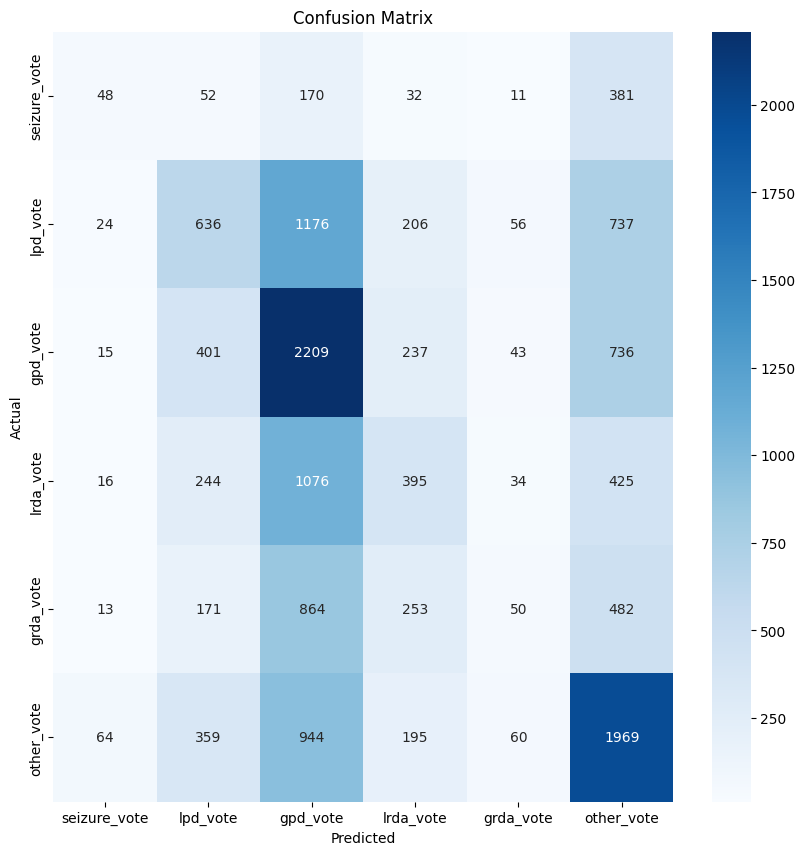

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Confusion Matrix')

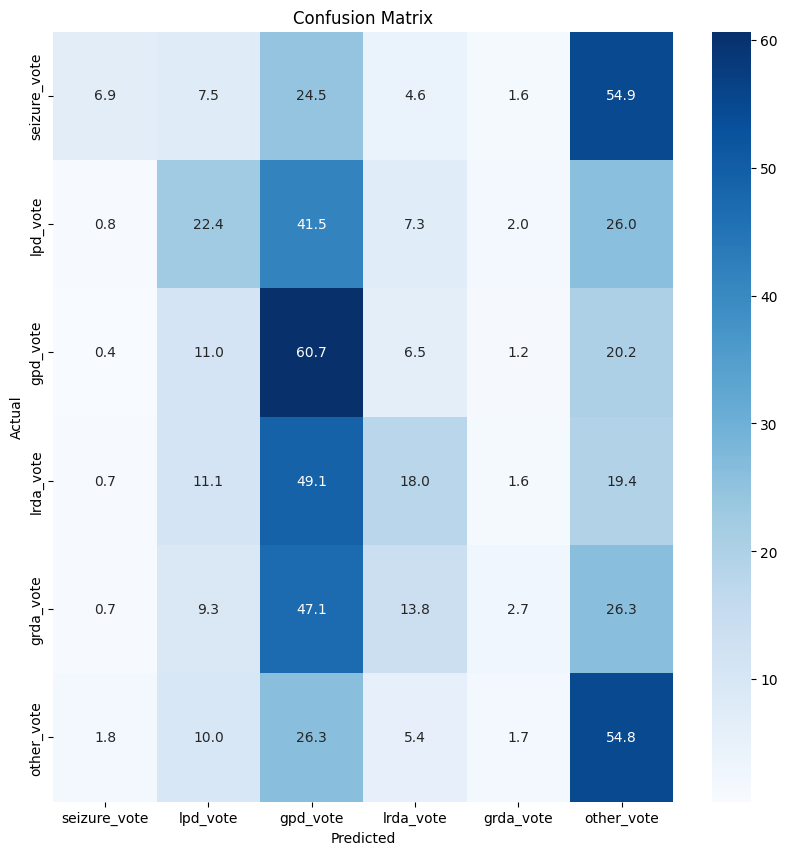

In [31]:
cm_p  = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm_p * 100, annot=True, fmt=".1f", cmap="Blues")
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
y_test[0], y_pred[0]

In [ ]:
# evaluate using kl divergence
from scipy.stats import entropy
kl_div = np.mean([entropy(y_test[i], y_pred[i]) for i in range(len(y_test))])
lk_base = np.mean([entropy(y_test[i], np.array([1/6]*6)) for i in range(len(y_test))])
print(f"KL div: {kl_div:.3f} (baseline: {lk_base:.3f})")